In [ ]:
import os
import numpy as np

import cvxpy as cp
import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision.datasets as datasets
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_blobs

import progressbar

plt.gcf().set_facecolor("white")
plt.rcParams.update({'font.size': 14})

<Figure size 432x288 with 0 Axes>

In [ ]:
### Conventions followed
# m = number of hidden neurons
# n = number of samples
# d = dimension of each input

In [ ]:
## Check what is the device type .. if gpu is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"[info] device :: {device}...")

[info] device :: cuda...


In [ ]:
def relu(x):
    """
      relu activation function
      @params x : float
      @returns float
    """

    return np.maximum(0, x)


def drelu(x):
    """
    relu's gradient
    @params x : float
    @returns float
    """
    return (x >= 0) * 1


def _D(X, samples, d):
    """
    generates D matrix - whose columns are sign patterns | Diag(column) == Diagonal matrix
    @params X :: data matrix
    @params samples :: total number of samples
    @params d :: dimension of the input

    @returns :: Matrix
    """
    D = np.empty((samples, 0))

    # Approximation
    for i in range(50000):
        u = np.random.randn(d, 1)
        D = np.append(D, (np.dot(X, u) >= 0) * 1.0, axis=1)
        D = np.unique(D, axis=1)
    return D


In [ ]:
def optmize_cvx(X, y_gt, n, d, beta=1e-4):
    """
    optimization based on cvx_py

    @params X :: data matrix
    @params y_gt :: true labels
    @params n :: # of samples
    @params d :: dimension of each sample
    @params beta :: regularization parameter

    @returns optimal value

    """

    D = _D(X, n, d)
    P = D.shape[1]

    v = cp.Variable((d, P))
    w = cp.Variable((d, P))

    y_pred = cp.sum(cp.multiply(D, X @ (v - w)), axis=1)

    # mixed_norm = norm(norm(X, p, axis=1), q)
    reg = cp.mixed_norm(v.T, p=2, q=1) + cp.mixed_norm(w.T, p=2, q=1)

    objective = 0.5 * cp.sum_squares(y_pred - y_gt) + beta * reg

    constraints = []
    constraints += [cp.multiply((2 * D - np.ones((n, P))), (X @ v)) >= 0]
    constraints += [cp.multiply((2 * D - np.ones((n, P))), (X @ w)) >= 0]

    problem = cp.Problem(cp.Minimize(objective), constraints)
    problem.solve()
    print("cvx optimal value:: ", problem.value)
    return problem.value

In [ ]:
class nn2layer(nn.Module):
    """
      2 layer Relu Neural Network
    """
    def __init__(self, d, num_hidden_units, classes):
        self.classes = classes
        super(nn2layer, self).__init__()

        self.layer1 = nn.Sequential(nn.Linear(d, num_hidden_units, bias=True), nn.ReLU())
        self.layer2 = nn.Linear(num_hidden_units, classes - 1, bias=True)

    def forward(self, x):
        num_n = x.shape[0]
        x = x.reshape(num_n, -1)

        output = self.layer2(self.layer1(x))
        return output

In [ ]:
def loss(h_theta_x, y, model, beta=1e-4):
    """
    computes the loss

    @params h_theta_x :: predicted value by the model
    @params y :: true label
    @params model :: instance of our NN model
    @params beta :: regularization parameter

    @returns optimal total_loss

    """
    total_loss = 0.5 * torch.linalg.norm(h_theta_x - y, 2) ** 2

    for layer, theta in enumerate(model.parameters()):
        if layer == 0:
            total_loss += 0.5 * beta * torch.linalg.norm(theta, 'fro') ** 2
        elif layer == 1:
            if len(theta.shape) == 1:
                total_loss += 0.5 * beta * torch.linalg.norm(theta, 2) ** 2
            elif len(theta.shape) == 2:
                total_loss += 0.5 * beta * sum([torch.linalg.norm(theta[:, j], 1) ** 2 for j in range(theta.shape[1])])

    return total_loss

In [ ]:
def get_data(n, d):
    """
    generates arbitrary data for 2 classes

    @params n :: total number of samples
    @params d :: dimension of each sample

    @returns data matrix, label vector
    """
    X = np.random.randn(n, d)
    y = ((np.linalg.norm(X[:, 0:d], axis=1) > 1) - 0.5) * 2

    return X, y

In [ ]:
def get_next_batch(X, y, batch_size):
    """
    generates arbitrary data for 2 classes

    @params X :: data matrix
    @params y :: labels
    @params y :: batch size

    @yields :: next batch from data matrix and correspond labels

    """

    n = X.shape[0]

    for i in range(0, n, batch_size):
        yield X[i:i + batch_size], y[i:i + batch_size]


In [ ]:
def sgd_solver(X_train, y_train, X_test, y_test, d, m, classes, epochs, batch_size, step_size=1e-3, beta=1e-4, schedule=1):
    """
    optimization via sgd

    @params X_train :: training data matrix
    @params y_train :: training labels
    @params X_test :: test data matrix
    @params y_test :: test labels
    @params epochs :: total epochs
    @params batch_size :: batch_size for SGD
    @params step_size :: learning rate
    @params beta :: regularization parameter
    @schedule :: optimization parameter

    @returns train_loss_history, train_acc_history, test_loss_history, test_acc_history

    """

    total_train_samples = X_train.shape[0]
    total_test_samples = X_test.shape[0]

    # print(f"[debug] d:: {d}, m:: {m}, classes:: {classes}")
    model = nn2layer(d, m, classes).to(device)

    optimizer = torch.optim.SGD(model.parameters(), lr=step_size, momentum=0.9)

    train_loss_history = []
    train_acc_history = []
    test_loss_history = []
    test_acc_history = []

    if total_test_samples > 0:
        x_test_batch = Variable(X_test).to(device)
        y_test_batch = Variable(y_test).to(device)

        output = torch.reshape(model(x_test_batch), (total_test_samples,))
        y_pred = torch.add((output >= 0), -0.5) * 2

        loss_val = loss(output, y_test_batch, model, beta)
        acc = torch.eq(y_pred, y_test_batch).cpu().float().sum() / total_test_samples

        test_loss_history.append(loss_val.item())
        test_acc_history.append(acc)

    if schedule == 1:
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=False, factor=0.5, eps=1e-12)
    elif schedule == 2:
        scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.99)

    i = 0
    for epoch in range(epochs):
        for (x_batch, y_batch) in get_next_batch(X_train, y_train, batch_size):
            x_batch = Variable(x_batch).to(device)
            y_batch = Variable(y_batch).to(device)

            output = torch.reshape(model(x_batch), (batch_size,))
            y_pred = torch.add((output >= 0), -0.5) * 2

            loss_val = loss(output, y_batch, model, beta)

            acc = torch.eq(y_pred, y_batch).cpu().float().sum() / batch_size

            optimizer.zero_grad()
            loss_val.backward()
            optimizer.step()

            train_loss_history.append(loss_val.item())
            train_acc_history.append(acc)

            i += 1

        if total_test_samples > 0:
            output = torch.reshape(model(x_test_batch), (total_test_samples,))
            y_pred = torch.add((output >= 0), -0.5) * 2

            loss_val = loss(output, y_test_batch, model, beta)
            acc = torch.eq(y_pred, y_test_batch).cpu().float().sum() / total_test_samples

            test_loss_history.append(loss_val.item())
            test_acc_history.append(acc)

        if epoch % 1000 == 0:
            print(f"[info] epoch {epoch}/{epochs} - train_loss: {train_loss_history[i - 1]:0.2f}, train_acc: {train_acc_history[i - 1]:0.2f}, test_loss: {test_loss_history[epoch + 1]:0.3f}, test_acc: {test_acc_history[epoch + 1]:0.3f}")

        if schedule > 0:
            scheduler.step(train_loss_history[i - 1])

    return train_loss_history, train_acc_history, test_loss_history, test_acc_history


In [ ]:
def optimize_nonconvex(d, m, classes, n, epochs, batch_size, trials):
    """
    optimization by non_convex NN approach

    @params d :: dimension
    @params n :: total samples
    @params classes :: number of classes
    @epochs :: total epochs
    @batch_size :: batch_size for SGD
    @trial :: number of runs for SGD

    @plots :: graphs for loss and accuracy

    """

    print("[info] generate data...")
    X, Y = get_data(n, d)

    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.5, random_state=95)

    num_train_samples = X_train.shape[0]
    num_test_samples = X_test.shape[0]

    # Type conversion
    X_train = torch.from_numpy(X_train).float()
    y_train = torch.from_numpy(y_train).float()
    X_test = torch.from_numpy(X_test).float()
    y_test = torch.from_numpy(y_test).float()

    fig = plt.figure(figsize=(15, 12))
    ax1 = fig.add_subplot(2, 2, 1)
    ax1.set_yscale('log')
    ax1.title.set_text("train obj vs iteration")
    plt.xlabel("iteration")
    plt.ylabel("objective")

    ax2 = fig.add_subplot(2, 2, 2)
    ax2.title.set_text("train acc vs iteration")
    plt.xlabel("iteration")
    plt.ylabel("accuracy")

    ax3 = fig.add_subplot(2, 2, 3)
    ax3.set_yscale('log')
    ax3.title.set_text("test obj  vs iteration")
    plt.xlabel("iteration")
    plt.ylabel("objective")

    ax4 = fig.add_subplot(2, 2, 4)
    ax4.title.set_text("test acc vs iteration")
    plt.xlabel("iteration")
    plt.ylabel("accuracy")


    colors = ['darkred', 'blue', 'lightcoral', 'lime', 'darkred', 'lightblue', 'green']
    for t in range(trials):
        train_loss_history, train_acc_history, test_loss_history, test_acc_history = sgd_solver(X_train, y_train, X_test, y_test, d, m, classes, epochs, batch_size)

        tag = 'SGD #'+str(t+1)
        ax1.plot(train_loss_history,color = colors[t], linewidth=1, label=tag)
        ax2.plot(train_acc_history,color = colors[t], linewidth=1, label=tag)
        ax3.plot(test_loss_history,color = colors[t], linewidth=1, label=tag)
        ax4.plot(test_acc_history,color = colors[t], linewidth=1, label=tag)

        ax1.legend(prop={'size': 10})
        ax2.legend(prop={'size': 10})
        ax3.legend(prop={'size': 10})
        ax4.legend(prop={'size': 10})


    # calling optimze_cvx
    X_train_1 = np.append(X_train, np.ones((num_train_samples, 1)), axis=1)
    cvx_opt_val = optmize_cvx(X_train_1, y_train, num_train_samples, d + 1, beta=1e-4)
    ax1.axhline(cvx_opt_val, color='black', linewidth=2, linestyle='-', label='CVX')

    plt.show()

[info] generate data...
[info] epoch 0/2000 - train_loss: 10.81, train_acc: 0.40, test_loss: 13.783, test_acc: 0.200
[info] epoch 1000/2000 - train_loss: 2.77, train_acc: 0.90, test_loss: 3.516, test_acc: 0.950
[info] epoch 0/2000 - train_loss: 16.42, train_acc: 0.75, test_loss: 9.702, test_acc: 0.900
[info] epoch 1000/2000 - train_loss: 1.59, train_acc: 1.00, test_loss: 3.265, test_acc: 1.000
[info] epoch 0/2000 - train_loss: 10.70, train_acc: 0.40, test_loss: 13.789, test_acc: 0.200
[info] epoch 1000/2000 - train_loss: 1.59, train_acc: 1.00, test_loss: 3.249, test_acc: 1.000
Convex program objective value (eq (8)):  0.0026715128533130374


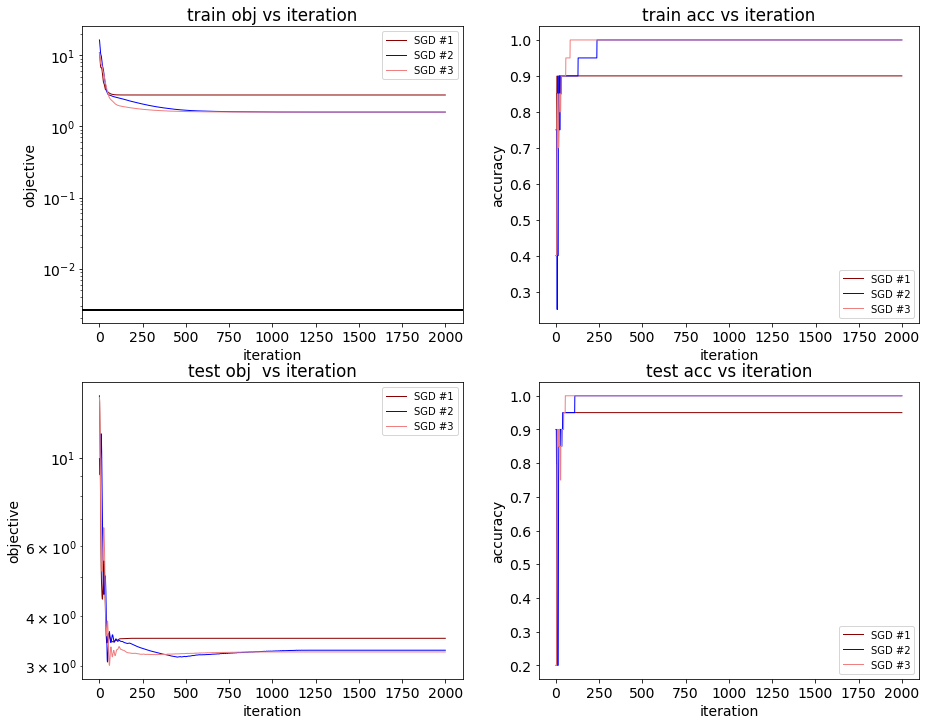

In [ ]:
d = 1
m = 5
classes = 2
n = 40
epochs = 2000
batch_size = 20
trials = 3
optimize_nonconvex(d, m, classes, n, epochs, batch_size, trials)

[info] generate data...
[info] epoch 0/2000 - train_loss: 3.56, train_acc: 0.80, test_loss: 2.855, test_acc: 0.900
[info] epoch 1000/2000 - train_loss: 3.20, train_acc: 0.80, test_loss: 1.980, test_acc: 0.900
[info] epoch 0/2000 - train_loss: 10.33, train_acc: 0.20, test_loss: 11.720, test_acc: 0.100
[info] epoch 1000/2000 - train_loss: 0.78, train_acc: 1.00, test_loss: 1.341, test_acc: 1.000
[info] epoch 0/2000 - train_loss: 4.10, train_acc: 0.90, test_loss: 4.007, test_acc: 1.000
[info] epoch 1000/2000 - train_loss: 0.26, train_acc: 1.00, test_loss: 2.402, test_acc: 1.000
[info] epoch 0/2000 - train_loss: 3.70, train_acc: 0.80, test_loss: 2.426, test_acc: 0.900
[info] epoch 1000/2000 - train_loss: 0.26, train_acc: 1.00, test_loss: 2.442, test_acc: 1.000
[info] epoch 0/2000 - train_loss: 3.48, train_acc: 0.80, test_loss: 2.340, test_acc: 0.900
[info] epoch 1000/2000 - train_loss: 0.00, train_acc: 1.00, test_loss: 0.471, test_acc: 1.000
Convex program objective value (eq (8)):  0.00071

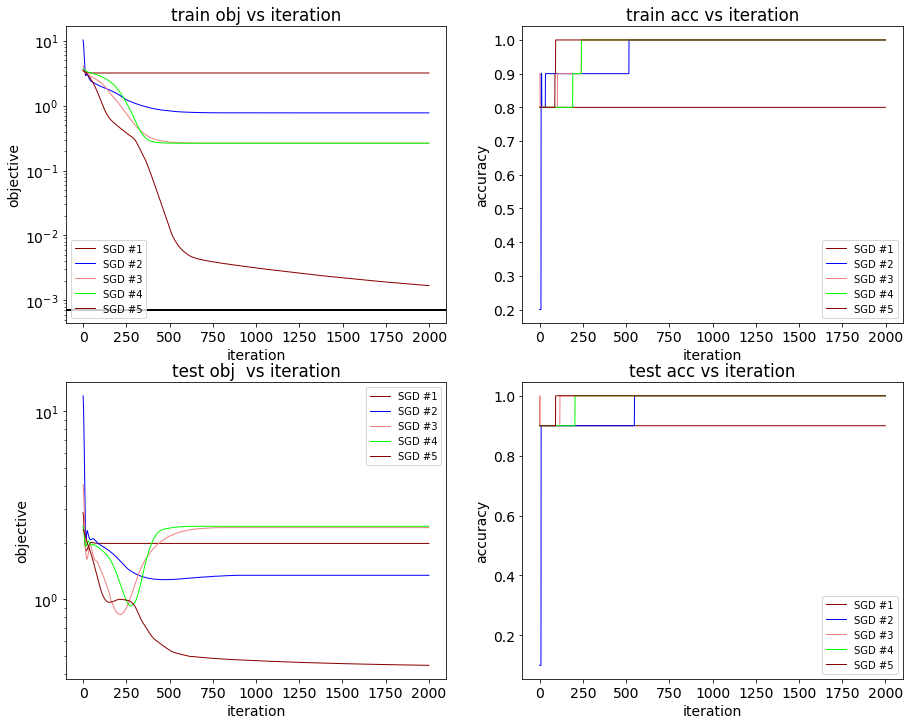

In [ ]:

d = 1
m = 5
n = 20
classes = 2
epochs = 2000
batch_size = 10
trials = 5

optimize_nonconvex(d, m, classes, n, epochs, batch_size, trials)

[info] generate data...
[info] epoch 0/2000 - train_loss: 7.50, train_acc: 0.50, test_loss: 3.113, test_acc: 0.700
[info] epoch 1000/2000 - train_loss: 0.11, train_acc: 1.00, test_loss: 1.550, test_acc: 1.000
[info] epoch 0/2000 - train_loss: 6.83, train_acc: 0.50, test_loss: 8.264, test_acc: 0.300
[info] epoch 1000/2000 - train_loss: 0.43, train_acc: 1.00, test_loss: 2.100, test_acc: 1.000
[info] epoch 0/2000 - train_loss: 5.00, train_acc: 0.50, test_loss: 6.626, test_acc: 0.100
[info] epoch 1000/2000 - train_loss: 0.44, train_acc: 1.00, test_loss: 1.802, test_acc: 1.000
[info] epoch 0/2000 - train_loss: 5.11, train_acc: 0.50, test_loss: 5.400, test_acc: 0.300
[info] epoch 1000/2000 - train_loss: 0.91, train_acc: 1.00, test_loss: 3.267, test_acc: 1.000
[info] epoch 0/2000 - train_loss: 4.93, train_acc: 0.60, test_loss: 4.508, test_acc: 0.700
[info] epoch 1000/2000 - train_loss: 0.91, train_acc: 1.00, test_loss: 3.396, test_acc: 1.000
Convex program objective value (eq (8)):  0.0018508

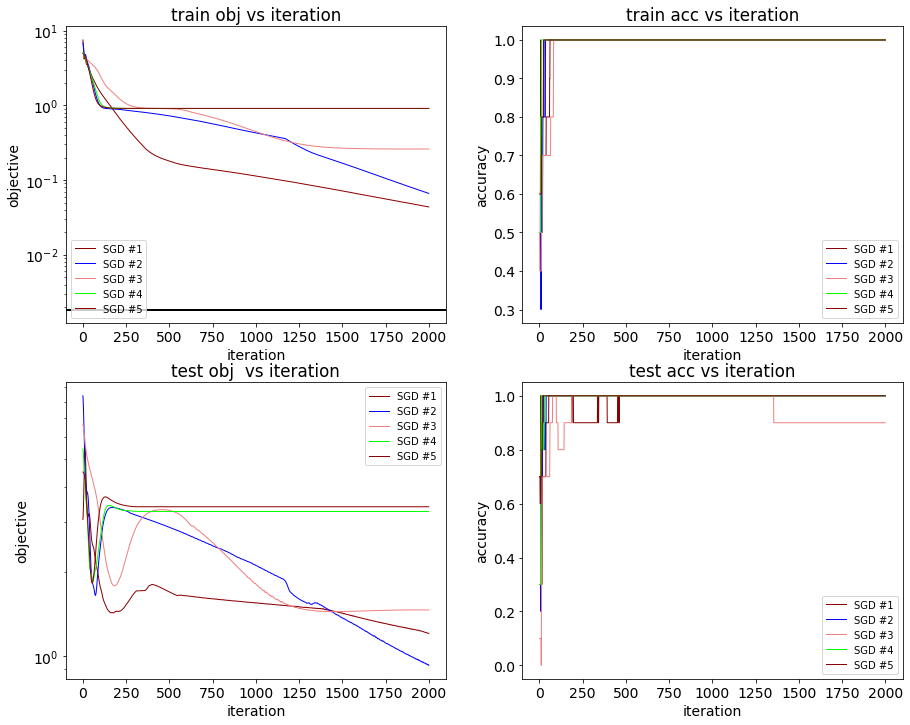

In [ ]:

d = 1
m = 10
n = 20
classes = 2
epochs = 2000
batch_size = 10
trials = 5

optimize_nonconvex(d, m, classes, n, epochs, batch_size, trials)

[info] generate data...
[info] epoch 0/2000 - train_loss: 7.93, train_acc: 0.20, test_loss: 7.563, test_acc: 0.100
[info] epoch 1000/2000 - train_loss: 0.01, train_acc: 1.00, test_loss: 3.193, test_acc: 0.700
[info] epoch 0/2000 - train_loss: 5.03, train_acc: 0.80, test_loss: 4.308, test_acc: 0.900
[info] epoch 1000/2000 - train_loss: 0.00, train_acc: 1.00, test_loss: 3.261, test_acc: 0.700
[info] epoch 0/2000 - train_loss: 4.23, train_acc: 0.80, test_loss: 3.676, test_acc: 0.900
[info] epoch 1000/2000 - train_loss: 0.01, train_acc: 1.00, test_loss: 3.118, test_acc: 0.700
[info] epoch 0/2000 - train_loss: 4.85, train_acc: 0.70, test_loss: 4.748, test_acc: 0.600
[info] epoch 1000/2000 - train_loss: 0.01, train_acc: 1.00, test_loss: 3.069, test_acc: 0.700
[info] epoch 0/2000 - train_loss: 4.74, train_acc: 0.70, test_loss: 4.011, test_acc: 0.600
[info] epoch 1000/2000 - train_loss: 0.01, train_acc: 1.00, test_loss: 2.990, test_acc: 0.700
Convex program objective value (eq (8)):  0.0007864

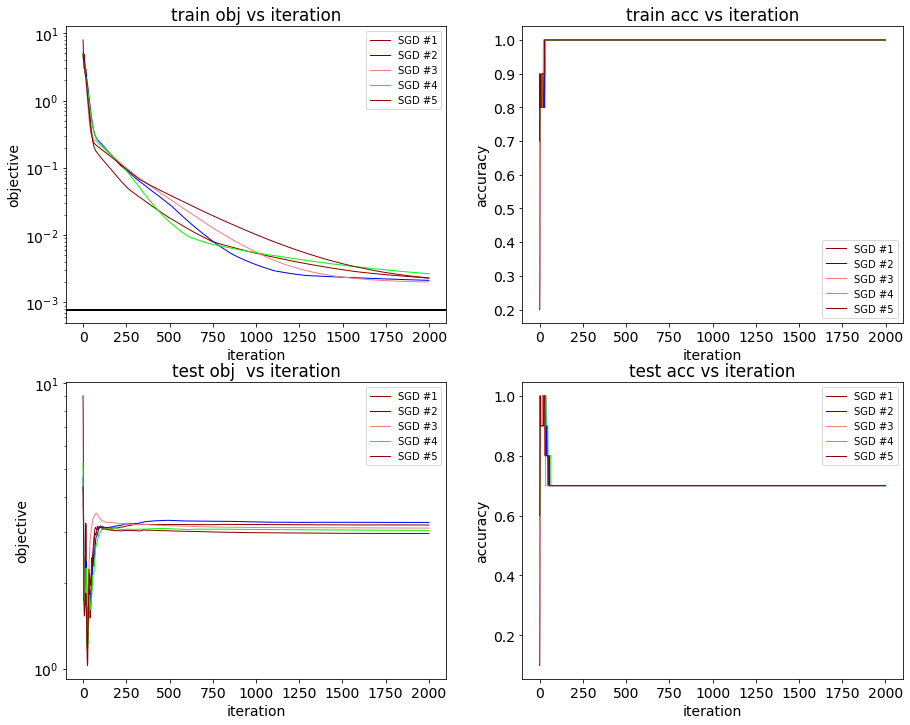

In [ ]:
d = 1
m = 50
n = 20
classes = 2
epochs = 2000
batch_size = 10
trials = 5

optimize_nonconvex(d, m, classes, n, epochs, batch_size, trials)

[info] generate data...
[info] epoch 0/2000 - train_loss: 5.57, train_acc: 0.60, test_loss: 7.112, test_acc: 0.400
[info] epoch 1000/2000 - train_loss: 0.40, train_acc: 1.00, test_loss: 1.042, test_acc: 0.900
[info] epoch 0/2000 - train_loss: 4.63, train_acc: 0.60, test_loss: 5.502, test_acc: 0.400
[info] epoch 1000/2000 - train_loss: 0.51, train_acc: 1.00, test_loss: 1.015, test_acc: 0.900
[info] epoch 0/2000 - train_loss: 5.07, train_acc: 0.60, test_loss: 5.115, test_acc: 0.400
[info] epoch 1000/2000 - train_loss: 0.66, train_acc: 1.00, test_loss: 1.264, test_acc: 0.900
[info] epoch 0/2000 - train_loss: 5.08, train_acc: 0.40, test_loss: 4.457, test_acc: 0.600
[info] epoch 1000/2000 - train_loss: 0.41, train_acc: 1.00, test_loss: 1.094, test_acc: 0.900
[info] epoch 0/2000 - train_loss: 5.00, train_acc: 0.60, test_loss: 4.689, test_acc: 0.500
[info] epoch 1000/2000 - train_loss: 0.36, train_acc: 1.00, test_loss: 1.014, test_acc: 0.900
Convex program objective value (eq (8)):  0.0040096

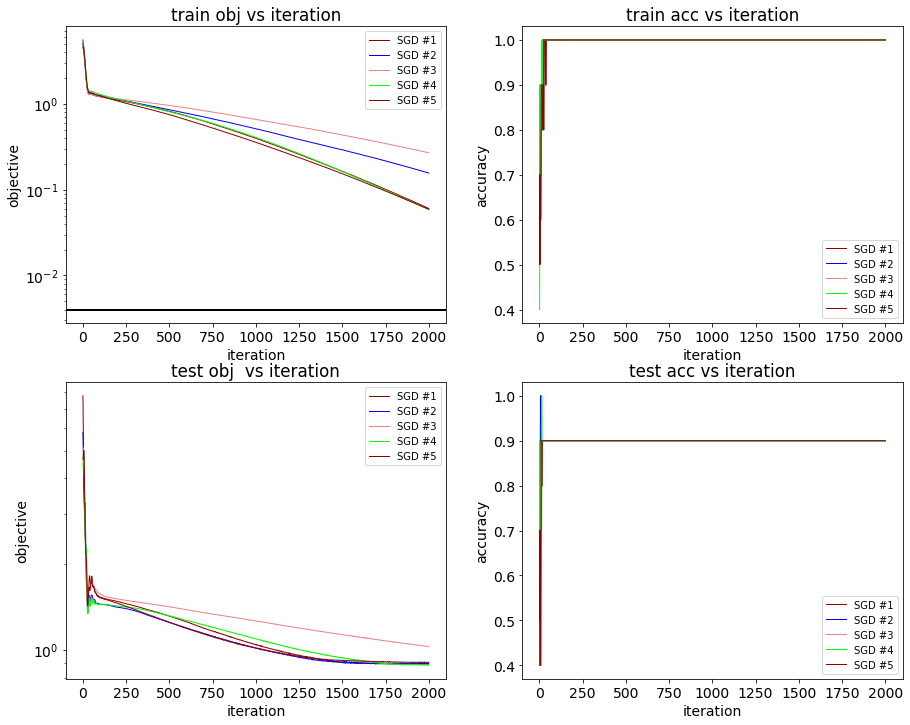

In [ ]:
d = 1
m = 100
n = 20
classes = 2
epochs = 2000
batch_size = 10
trials = 5

optimize_nonconvex(d, m, classes, n, epochs, batch_size, trials)

[info] generate data...
[info] epoch 0/2000 - train_loss: 5.11, train_acc: 0.60, test_loss: 5.157, test_acc: 0.500
[info] epoch 1000/2000 - train_loss: 1.10, train_acc: 0.90, test_loss: 0.695, test_acc: 1.000
[info] epoch 0/2000 - train_loss: 4.63, train_acc: 0.60, test_loss: 5.192, test_acc: 0.500
[info] epoch 1000/2000 - train_loss: 1.08, train_acc: 0.90, test_loss: 0.678, test_acc: 1.000
[info] epoch 0/2000 - train_loss: 5.95, train_acc: 0.50, test_loss: 8.265, test_acc: 0.100
[info] epoch 1000/2000 - train_loss: 1.12, train_acc: 0.90, test_loss: 0.722, test_acc: 1.000
[info] epoch 0/2000 - train_loss: 4.97, train_acc: 0.50, test_loss: 6.230, test_acc: 0.100
[info] epoch 1000/2000 - train_loss: 1.06, train_acc: 0.90, test_loss: 0.690, test_acc: 0.900
[info] epoch 0/2000 - train_loss: 5.60, train_acc: 0.50, test_loss: 6.419, test_acc: 0.200
[info] epoch 1000/2000 - train_loss: 1.08, train_acc: 0.90, test_loss: 0.675, test_acc: 1.000
Convex program objective value (eq (8)):  0.0134581

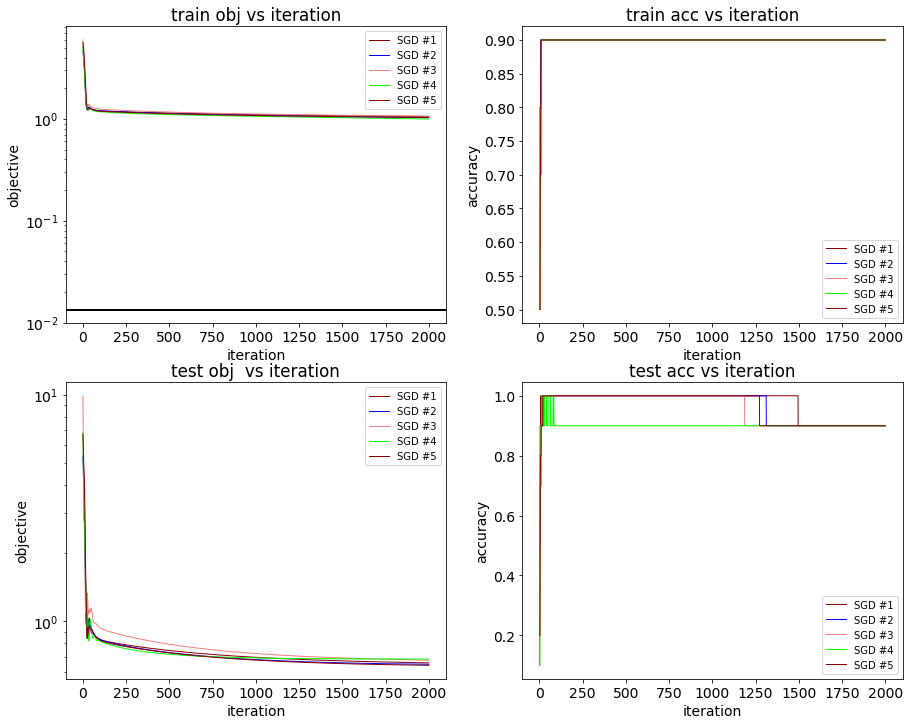

In [ ]:
d = 1
m = 150
n = 20
classes = 2
epochs = 2000
batch_size = 10
trials = 5

optimize_nonconvex(d, m, classes, n, epochs, batch_size, trials)

[info] generate data...
[info] epoch 0/1000 - train_loss: 18.93, train_acc: 0.74, test_loss: 87.739, test_acc: 0.800
[info] epoch 0/1000 - train_loss: 20.28, train_acc: 0.74, test_loss: 96.890, test_acc: 0.760
[info] epoch 0/1000 - train_loss: 20.32, train_acc: 0.74, test_loss: 86.933, test_acc: 0.868
Convex program objective value (eq (8)):  0.05131232382939862


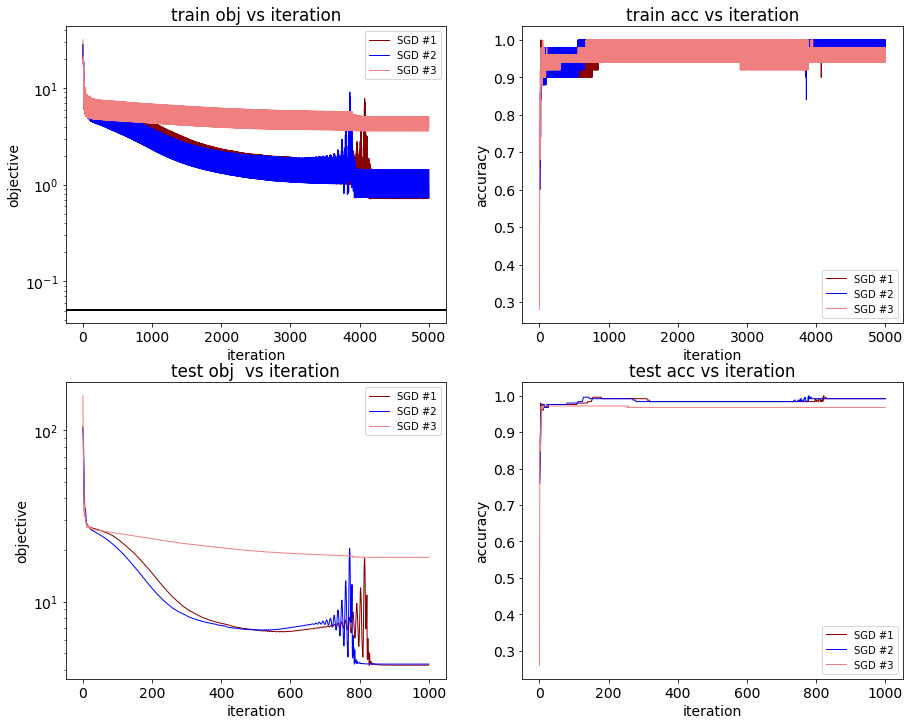

In [ ]:
d = 1
m = 10
n = 500
classes = 2
epochs = 1000
batch_size = 50
trials = 3

optimize_nonconvex(d, m, classes, n, epochs, batch_size, trials)

[info] generate data...
[info] epoch 0/1000 - train_loss: 20.58, train_acc: 0.83, test_loss: 97.546, test_acc: 0.826
[info] epoch 0/1000 - train_loss: 27.33, train_acc: 0.76, test_loss: 105.330, test_acc: 0.834
[info] epoch 0/1000 - train_loss: 30.70, train_acc: 0.74, test_loss: 107.404, test_acc: 0.842
[info] epoch 0/1000 - train_loss: 30.91, train_acc: 0.74, test_loss: 123.044, test_acc: 0.772
[info] epoch 0/1000 - train_loss: 36.50, train_acc: 0.72, test_loss: 136.989, test_acc: 0.854
Convex program objective value (eq (8)):  0.10616646218475738


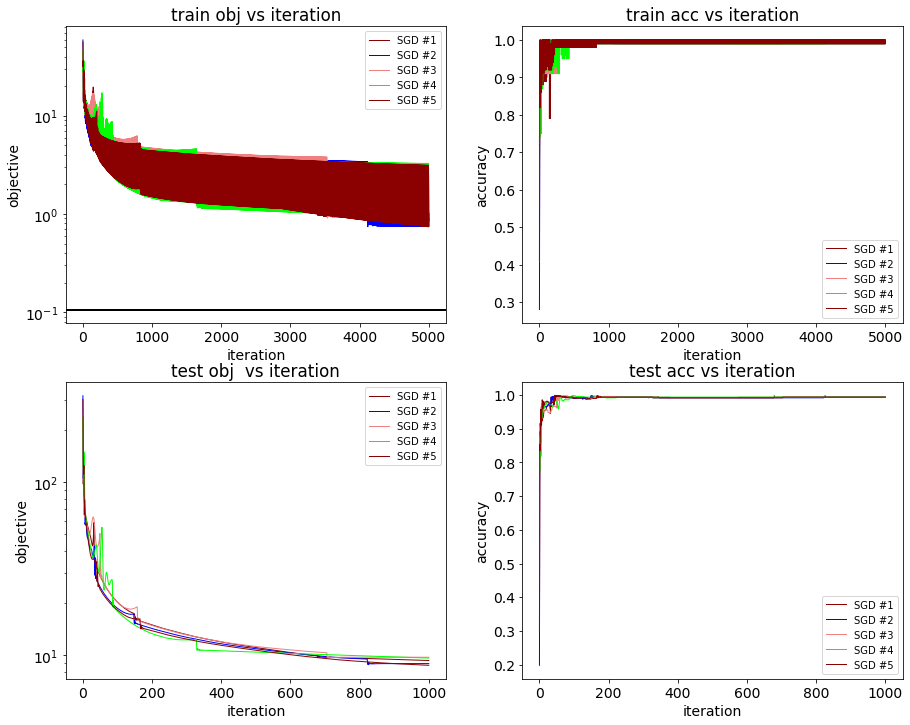

In [ ]:
d = 1
m = 40
n = 1000
classes = 2
epochs = 1000
batch_size = 100
trials = 5

optimize_nonconvex(d, m, classes, n, epochs, batch_size, trials)

## CIFAR dataset

In [ ]:
directory = os.path.dirname(os.path.realpath("./"))
normalize = transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
train_dataset = datasets.CIFAR10(directory, train=True, download=True, transform=transforms.Compose([transforms.ToTensor(), normalize,]))
test_dataset = datasets.CIFAR10(directory, train=False, download=True, transform=transforms.Compose([transforms.ToTensor(), normalize,]))

Files already downloaded and verified
Files already downloaded and verified


In [ ]:

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=50000, shuffle=True, pin_memory=True, sampler=None)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=10000, shuffle=False, pin_memory=True, sampler=None)

for train_X, train_y in train_loader:
    pass

for test_X, test_y in test_loader:
    pass

train_X = train_X.view(train_X.shape[0], -1)
test_X = test_X.view(test_X.shape[0], -1)

idx_01 = torch.where(train_y <= 1)[0]
X_train = train_X[idx_01]
y_train = train_y[idx_01]

idx_01 = torch.where(test_y <= 1)[0]
X_test = test_X[idx_01]
y_test = test_y[idx_01]

y_train = (y_train - 0.5) * 2
y_test = (y_test - 0.5) * 2


In [ ]:
idx_1 = torch.where(y_train == 1)[0]
idx_0 = torch.where(y_train == -1)[0]

idx_1 = idx_1[0:100]
idx_0 = idx_0[0:100]
index_01_class = torch.cat((idx_1, idx_0), dim=0)
print(idx_1.shape, idx_0.shape, index_01_class.shape)

X_train_sub = X_train[index_01_class]
y_train_sub = y_train[index_01_class]

idx_1 = torch.where(y_test == 1)[0]
idx_0 = torch.where(y_test == -1)[0]

idx_1 = idx_1[0:10]
idx_0 = idx_0[0:10]
index_01_class = torch.cat((idx_1, idx_0), dim=0)
print(idx_1.shape, idx_0.shape, index_01_class.shape)

X_test_sub= X_test[index_01_class]
y_test_sub = y_test[index_01_class]

print(f"train_sub size {X_train_sub.shape}")
print(f"test_sub size {X_test_sub.shape}")

torch.Size([100]) torch.Size([100]) torch.Size([200])
torch.Size([10]) torch.Size([10]) torch.Size([20])
train_sub size torch.Size([200, 3072])
test_sub size torch.Size([20, 3072])


In [ ]:
d = X_train_sub.shape[1]
m = 100
classes = 2
n = X_train_sub.shape[0]
epochs = 200
batch_size = n // 1
trials = 5
step_size = 1e-4
beta = 1e-3

fig = plt.figure(figsize=(15, 12))
ax1 = fig.add_subplot(2, 2, 1)
ax1.set_yscale('log')
ax1.title.set_text("train obj vs iteration")
plt.xlabel("iteration")
plt.ylabel("objective")
plt.grid()

ax2 = fig.add_subplot(2, 2, 2)
ax2.title.set_text("train acc vs iteration")
plt.xlabel("iteration")
plt.ylabel("accuracy")
plt.grid()

ax3 = fig.add_subplot(2, 2, 3)
ax3.set_yscale('log')
ax3.title.set_text("test obj  vs iteration")
plt.xlabel("iteration")
plt.ylabel("objective")
plt.grid()

ax4 = fig.add_subplot(2, 2, 4)
ax4.title.set_text("test acc vs iteration")
plt.xlabel("iteration")
plt.ylabel("accuracy")
plt.grid()

for trial in range(trials):

    train_loss_history, train_acc_history, test_loss_history, test_acc_history = sgd_solver(X_train_sub, y_train_sub, X_test_sub, y_test_sub, d, m, classes, epochs, batch_size)

    ax1.plot(train_loss_history,linewidth=1, label=f"trial {trial + 1}")
    ax2.plot(train_acc_history, linewidth=1, label=f"trial {trial + 1}")
    ax3.plot(test_loss_history, linewidth=1, label=f"trial {trial + 1}")
    ax4.plot(test_acc_history, linewidth=1, label=f"trial {trial + 1}")


# calling optimze_cvx
X_train_sub_1 = np.append(X_train_sub, np.ones((n, 1)), axis=1)

cvx_opt_val = optmize_cvx(X_train_sub_1, y_train_sub, n, d + 1, beta=1e-4)
ax1.axhline(cvx_opt_val, color='black', linewidth=2, linestyle='-', label='optimal')
plt.show()

[info] epoch 0/200 - train_loss: 129.72, train_acc: 0.32, test_loss: 1238.983, test_acc: 0.750
[info] epoch 0/200 - train_loss: 96.52, train_acc: 0.56, test_loss: 883.893, test_acc: 0.750
[info] epoch 0/200 - train_loss: 93.41, train_acc: 0.61, test_loss: 499.436, test_acc: 0.750
[info] epoch 0/200 - train_loss: 118.35, train_acc: 0.46, test_loss: 1379.687, test_acc: 0.750
[info] epoch 0/200 - train_loss: 109.65, train_acc: 0.44, test_loss: 848.185, test_acc: 0.750


## References

Following references were used for coding
*  https://github.com/pilancilab/convex_nn (Repository of the authors of the paper)